In [3]:
import pandas as pd
import os
import numpy as np

cur_dir = os.getcwd()
path = os.path.join(cur_dir,'dataset','train.csv')
path

df_train = pd.read_csv( os.path.join(cur_dir,'dataset','train.csv'), sep=',' )
df_movies = pd.read_csv( os.path.join(cur_dir,'dataset','movies.csv'), sep='::' )
df_users = pd.read_csv( os.path.join(cur_dir,'dataset','users.csv'), sep='::' )
df_test = pd.read_csv( os.path.join(cur_dir,'dataset','test.csv'), sep=',' )
df_SampleSubmisson = pd.read_csv( os.path.join(cur_dir,'dataset','SampleSubmisson.csv'), sep=',' )

mean = df_train.Rating.mean()
std = df_train.Rating.std()
df_train['Rating_normalized'] = (df_train['Rating'] - mean)/std

all_user = np.concatenate([df_train.UserID,df_test.UserID],axis=0)
all_movie = np.concatenate([df_train.MovieID,df_test.MovieID],axis=0)
print(all_user.shape)
print(all_movie.shape)
all_user = np.unique(all_user)
all_movie = np.unique(all_movie)
print(all_user.shape)
print(all_movie.shape)


df_all_movie = pd.DataFrame({'movie_id':all_movie})
df_all_movie['movie_index'] = df_all_movie.index

df_all_user = pd.DataFrame({'user_id':all_user})
df_all_user['user_index'] = df_all_user.index


movie_id_to_index = df_all_movie.set_index('movie_id').to_dict()
movie_id_to_index = movie_id_to_index['movie_index']
user_id_to_index = df_all_user.set_index('user_id').to_dict()
user_id_to_index = user_id_to_index['user_index']

df_train['user_index'] =  df_train.apply(lambda row: user_id_to_index[row.UserID] ,axis=1)
df_train['movie_index'] =  df_train.apply(lambda row: movie_id_to_index[row.MovieID] ,axis=1)

df_train



/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


(1000209,)
(1000209,)
(6040,)
(3706,)


In [63]:
df_train

,TrainDataID,UserID,MovieID,Rating,Rating_normalized,user_index,movie_index
0,1,796,1193,5,1.269845,795,1104
1,2,796,661,3,-0.520828,795,639
2,3,796,914,3,-0.520828,795,853
3,4,796,3408,4,0.374509,795,3177
4,5,796,2355,5,1.269845,795,2162
5,6,796,1197,3,-0.520828,795,1107
6,7,796,1287,5,1.269845,795,1195
7,8,796,2804,5,1.269845,795,2599
8,9,796,919,4,0.374509,795,858
9,10,796,595,5,1.269845,795,581


In [64]:

user_train = df_train.user_index
movie_train = df_train.movie_index
rating_train = df_train.Rating


In [4]:
from keras.layers import Input, Dense, Embedding, Flatten, dot, add, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
import keras.backend as K
from sklearn.utils import shuffle
import matplotlib.pylab as plt

Using TensorFlow backend.


In [27]:
n_users= df_all_user.shape[0]
n_movies= df_all_movie.shape[0]
latent_dim=20
n_movies

3706

In [28]:
# build model---------------------------------------------------------
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

user_vecter = Embedding(n_users, latent_dim, embeddings_initializer="random_normal")(user_input)
user_vecter = Flatten()(user_vecter)
movie_vecter = Embedding(n_movies, latent_dim, embeddings_initializer="random_normal")(movie_input)
movie_vecter = Flatten()(movie_vecter)
rating_predict = dot([user_vecter,movie_vecter],axes=1)

model_dot = Model([user_input,movie_input],rating_predict)

# compile model---------------------------------------------------------
def rmse(y_true, y_pred):
    y_pred = K.clip(y_pred, 1.0, 5.0)
    return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
get_custom_objects().update({"rmse": rmse})

model_dot.compile(loss="mse", optimizer="adam", metrics=[rmse])

model_dot.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 20)        120800      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 20)        74120       input_6[0][0]                    
__________________________________________________________________________________________________
flatten_5 

In [29]:
batch_size=1000
epochs = 10
user_train2, movie_train2, rating_train2 = shuffle(user_train, movie_train, rating_train)

history_dot = model_dot.fit([user_train2, movie_train2],
                    rating_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    shuffle=True)

Train on 809885 samples, validate on 89988 samples
Epoch 1/10
809885/809885 [==============================] - 4s 5us/step - loss: 11.4201 - rmse: 2.6839 - val_loss: 3.5295 - val_rmse: 1.8466
Epoch 2/10
809885/809885 [==============================] - 4s 5us/step - loss: 1.6494 - rmse: 1.2563 - val_loss: 1.0616 - val_rmse: 1.0270
Epoch 3/10
809885/809885 [==============================] - 4s 5us/step - loss: 0.9401 - rmse: 0.9673 - val_loss: 0.8913 - val_rmse: 0.9424
Epoch 4/10
809885/809885 [==============================] - 4s 5us/step - loss: 0.8570 - rmse: 0.9245 - val_loss: 0.8552 - val_rmse: 0.9234
Epoch 5/10
809885/809885 [==============================] - 4s 5us/step - loss: 0.8355 - rmse: 0.9131 - val_loss: 0.8430 - val_rmse: 0.9169
Epoch 6/10
809885/809885 [==============================] - 4s 5us/step - loss: 0.8250 - rmse: 0.9074 - val_loss: 0.8362 - val_rmse: 0.9133
Epoch 7/10
809885/809885 [==============================] - 4s 5us/step - loss: 0.8154 - rmse: 0.9022 - val_

# tsne

In [30]:
df_movies = pd.read_csv( os.path.join(cur_dir,'dataset','movies.csv'), sep='::' )
df_movies['Genres_first'] = df_movies.apply(lambda row: row['Genres'].split('|')[0] ,axis=1)
df_movies



/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,movieID,Title,Genres,Genres_first
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,Comedy
4,5,Father of the Bride Part II (1995),Comedy,Comedy
5,6,Heat (1995),Action|Crime|Thriller,Action
6,7,Sabrina (1995),Comedy|Romance,Comedy
7,8,Tom and Huck (1995),Adventure|Children's,Adventure
8,9,Sudden Death (1995),Action,Action
9,10,GoldenEye (1995),Action|Adventure|Thriller,Action


In [54]:
genre_list = list(df_movies['Genres_first'].value_counts().index)
# genre_list.index('Comedy')
genre_list

['Drama',
 'Comedy',
 'Action',
 'Horror',
 'Adventure',
 'Crime',
 'Documentary',
 'Thriller',
 'Animation',
 "Children's",
 'Romance',
 'Sci-Fi',
 'Mystery',
 'Western',
 'Film-Noir',
 'Musical',
 'War',
 'Fantasy']

In [58]:
df_movies['Genres_label'] = df_movies.apply(lambda row: genre_list.index( row['Genres_first'] ) ,axis=1)
df_movies = df_movies.rename(columns={'movieID': 'movie_id'})
df_movies



,movie_id,Title,Genres,Genres_first,Genres_label
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation,8
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure,4
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,1
3,4,Waiting to Exhale (1995),Comedy|Drama,Comedy,1
4,5,Father of the Bride Part II (1995),Comedy,Comedy,1
5,6,Heat (1995),Action|Crime|Thriller,Action,2
6,7,Sabrina (1995),Comedy|Romance,Comedy,1
7,8,Tom and Huck (1995),Adventure|Children's,Adventure,4
8,9,Sudden Death (1995),Action,Action,2
9,10,GoldenEye (1995),Action|Adventure|Thriller,Action,2


In [61]:
df_all_movie2 = pd.merge(df_all_movie, df_movies, how='left', on=['movie_id'])
df_all_movie2 

,movie_id,movie_index,Title,Genres,Genres_first,Genres_label
0,1,0,Toy Story (1995),Animation|Children's|Comedy,Animation,8
1,2,1,Jumanji (1995),Adventure|Children's|Fantasy,Adventure,4
2,3,2,Grumpier Old Men (1995),Comedy|Romance,Comedy,1
3,4,3,Waiting to Exhale (1995),Comedy|Drama,Comedy,1
4,5,4,Father of the Bride Part II (1995),Comedy,Comedy,1
5,6,5,Heat (1995),Action|Crime|Thriller,Action,2
6,7,6,Sabrina (1995),Comedy|Romance,Comedy,1
7,8,7,Tom and Huck (1995),Adventure|Children's,Adventure,4
8,9,8,Sudden Death (1995),Action,Action,2
9,10,9,GoldenEye (1995),Action|Adventure|Thriller,Action,2


In [65]:
df_all_movie2['Genres_label'].values

array([8, 4, 1, ..., 0, 0, 0])

# embedding: (1,) => (1,3706) => (1,20)

In [32]:
movie_embedding = np.array(model_dot.layers[3].get_weights())
print(movie_embedding.shape)
movie_embedding = movie_embedding.squeeze()
print(movie_embedding.shape)

(1, 3706, 20)
(3706, 20)


In [67]:
dim_list = ['dim_%s'%(i) for i in range(movie_embedding.shape[1])]
dim_list

['dim_0',
 'dim_1',
 'dim_2',
 'dim_3',
 'dim_4',
 'dim_5',
 'dim_6',
 'dim_7',
 'dim_8',
 'dim_9',
 'dim_10',
 'dim_11',
 'dim_12',
 'dim_13',
 'dim_14',
 'dim_15',
 'dim_16',
 'dim_17',
 'dim_18',
 'dim_19']

In [82]:
df_movie_embedding = pd.DataFrame(movie_embedding,columns=dim_list)
df_movie_embedding



,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19
0,-0.732337,-0.365239,-0.459748,-0.589725,-0.542566,-0.583875,0.430089,-0.849782,0.606635,0.453011,-0.554339,0.669651,0.464944,0.672188,0.345300,0.720708,0.170268,0.665386,-0.709377,0.679193
1,-0.550519,-0.334070,-0.343489,-0.457069,-0.472383,-0.528499,0.537981,-0.531617,0.336743,0.518476,-0.246693,0.475577,0.493185,0.415642,0.652153,0.587474,-0.170574,0.197609,-0.360578,0.423417
2,-0.440421,-0.478279,-0.488933,-0.413262,-0.339757,-0.455158,0.421762,-0.536622,0.237299,0.324459,-0.450202,0.515255,0.359508,0.500335,0.779255,0.471784,-0.398119,0.435415,-0.390874,0.225082
3,-0.238918,-0.392182,-0.440461,-0.371663,-0.408229,-0.336812,0.355279,-0.353491,0.470349,0.267404,-0.460052,0.452620,0.477493,0.440162,0.417506,0.410555,-0.451406,0.259611,-0.455268,0.415836
4,-0.255793,-0.450456,-0.474389,-0.466547,-0.464254,-0.536994,0.412624,-0.417905,0.264415,0.470426,-0.311962,0.649179,0.454990,0.506378,0.661902,0.355900,-0.543212,0.081905,-0.368469,0.384725
5,-0.616851,-0.291659,-0.619242,-0.685442,-0.603325,-0.455926,0.295604,-0.615080,0.529187,0.621303,-0.617317,0.508210,0.462618,0.567678,0.598498,0.529569,-0.285480,0.579244,-0.575497,0.274589
6,-0.362263,-0.371905,-0.611164,-0.455835,-0.341505,-0.476725,0.517845,-0.383187,0.432905,0.586384,-0.492235,0.664702,0.456177,0.461241,0.496591,0.581036,-0.560620,0.255045,-0.494553,0.425534
7,-0.393090,-0.467902,-0.319800,-0.467647,-0.381870,-0.429674,0.509146,-0.513812,0.318780,0.488569,-0.408648,0.453149,0.365925,0.458859,0.425599,0.502222,-0.479511,0.345785,-0.370377,0.383327
8,-0.309161,-0.547100,-0.412079,-0.392118,-0.403111,-0.359702,0.547588,-0.297150,0.296813,0.554453,-0.267567,0.300077,0.517969,0.304647,0.457659,0.440922,-0.300592,0.388945,-0.186658,0.320378
9,-0.657731,-0.512022,-0.397137,-0.501261,-0.480349,-0.485168,0.580721,-0.390047,0.477638,0.541658,-0.281785,0.577449,0.589962,0.619901,0.718416,0.609197,0.273433,0.471547,-0.454844,0.289732


In [83]:
df_movie_embedding['Genres_label'] = df_all_movie2['Genres_label'].values
df_movie_embedding

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,Genres_label
0,-0.732337,-0.365239,-0.459748,-0.589725,-0.542566,-0.583875,0.430089,-0.849782,0.606635,0.453011,...,0.669651,0.464944,0.672188,0.345300,0.720708,0.170268,0.665386,-0.709377,0.679193,8
1,-0.550519,-0.334070,-0.343489,-0.457069,-0.472383,-0.528499,0.537981,-0.531617,0.336743,0.518476,...,0.475577,0.493185,0.415642,0.652153,0.587474,-0.170574,0.197609,-0.360578,0.423417,4
2,-0.440421,-0.478279,-0.488933,-0.413262,-0.339757,-0.455158,0.421762,-0.536622,0.237299,0.324459,...,0.515255,0.359508,0.500335,0.779255,0.471784,-0.398119,0.435415,-0.390874,0.225082,1
3,-0.238918,-0.392182,-0.440461,-0.371663,-0.408229,-0.336812,0.355279,-0.353491,0.470349,0.267404,...,0.452620,0.477493,0.440162,0.417506,0.410555,-0.451406,0.259611,-0.455268,0.415836,1
4,-0.255793,-0.450456,-0.474389,-0.466547,-0.464254,-0.536994,0.412624,-0.417905,0.264415,0.470426,...,0.649179,0.454990,0.506378,0.661902,0.355900,-0.543212,0.081905,-0.368469,0.384725,1
5,-0.616851,-0.291659,-0.619242,-0.685442,-0.603325,-0.455926,0.295604,-0.615080,0.529187,0.621303,...,0.508210,0.462618,0.567678,0.598498,0.529569,-0.285480,0.579244,-0.575497,0.274589,2
6,-0.362263,-0.371905,-0.611164,-0.455835,-0.341505,-0.476725,0.517845,-0.383187,0.432905,0.586384,...,0.664702,0.456177,0.461241,0.496591,0.581036,-0.560620,0.255045,-0.494553,0.425534,1
7,-0.393090,-0.467902,-0.319800,-0.467647,-0.381870,-0.429674,0.509146,-0.513812,0.318780,0.488569,...,0.453149,0.365925,0.458859,0.425599,0.502222,-0.479511,0.345785,-0.370377,0.383327,4
8,-0.309161,-0.547100,-0.412079,-0.392118,-0.403111,-0.359702,0.547588,-0.297150,0.296813,0.554453,...,0.300077,0.517969,0.304647,0.457659,0.440922,-0.300592,0.388945,-0.186658,0.320378,2
9,-0.657731,-0.512022,-0.397137,-0.501261,-0.480349,-0.485168,0.580721,-0.390047,0.477638,0.541658,...,0.577449,0.589962,0.619901,0.718416,0.609197,0.273433,0.471547,-0.454844,0.289732,2


In [84]:
arr_tsne = df_movie_embedding[dim_list].values
arr_tsne.shape

(3706, 20)

In [85]:
import time

from sklearn.manifold import TSNE


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(  arr_tsne )

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3706 samples in 0.007s...
[t-SNE] Computed neighbors for 3706 samples in 0.774s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3706
[t-SNE] Computed conditional probabilities for sample 2000 / 3706
[t-SNE] Computed conditional probabilities for sample 3000 / 3706
[t-SNE] Computed conditional probabilities for sample 3706 / 3706
[t-SNE] Mean sigma: 0.140998
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.247963
[t-SNE] KL divergence after 300 iterations: 2.200629


In [86]:
tsne_results.shape


(3706, 2)

In [87]:
df_movie_embedding['x-tsne'] = tsne_results[:,0]
df_movie_embedding['y-tsne'] = tsne_results[:,1]
df_movie_embedding

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,Genres_label,x-tsne,y-tsne
0,-0.732337,-0.365239,-0.459748,-0.589725,-0.542566,-0.583875,0.430089,-0.849782,0.606635,0.453011,...,0.672188,0.345300,0.720708,0.170268,0.665386,-0.709377,0.679193,8,-4.418258,9.059649
1,-0.550519,-0.334070,-0.343489,-0.457069,-0.472383,-0.528499,0.537981,-0.531617,0.336743,0.518476,...,0.415642,0.652153,0.587474,-0.170574,0.197609,-0.360578,0.423417,4,2.971297,5.564763
2,-0.440421,-0.478279,-0.488933,-0.413262,-0.339757,-0.455158,0.421762,-0.536622,0.237299,0.324459,...,0.500335,0.779255,0.471784,-0.398119,0.435415,-0.390874,0.225082,1,1.874215,-2.405282
3,-0.238918,-0.392182,-0.440461,-0.371663,-0.408229,-0.336812,0.355279,-0.353491,0.470349,0.267404,...,0.440162,0.417506,0.410555,-0.451406,0.259611,-0.455268,0.415836,1,3.853426,-5.188541
4,-0.255793,-0.450456,-0.474389,-0.466547,-0.464254,-0.536994,0.412624,-0.417905,0.264415,0.470426,...,0.506378,0.661902,0.355900,-0.543212,0.081905,-0.368469,0.384725,1,2.174758,-2.010710
5,-0.616851,-0.291659,-0.619242,-0.685442,-0.603325,-0.455926,0.295604,-0.615080,0.529187,0.621303,...,0.567678,0.598498,0.529569,-0.285480,0.579244,-0.575497,0.274589,2,-4.269547,5.964445
6,-0.362263,-0.371905,-0.611164,-0.455835,-0.341505,-0.476725,0.517845,-0.383187,0.432905,0.586384,...,0.461241,0.496591,0.581036,-0.560620,0.255045,-0.494553,0.425534,1,-3.448918,-2.927542
7,-0.393090,-0.467902,-0.319800,-0.467647,-0.381870,-0.429674,0.509146,-0.513812,0.318780,0.488569,...,0.458859,0.425599,0.502222,-0.479511,0.345785,-0.370377,0.383327,4,2.926656,-2.373268
8,-0.309161,-0.547100,-0.412079,-0.392118,-0.403111,-0.359702,0.547588,-0.297150,0.296813,0.554453,...,0.304647,0.457659,0.440922,-0.300592,0.388945,-0.186658,0.320378,2,5.203804,1.532517
9,-0.657731,-0.512022,-0.397137,-0.501261,-0.480349,-0.485168,0.580721,-0.390047,0.477638,0.541658,...,0.619901,0.718416,0.609197,0.273433,0.471547,-0.454844,0.289732,2,0.597166,8.900173


TypeError: '>=' not supported between instances of 'numpy.ndarray' and 'numpy.ndarray'

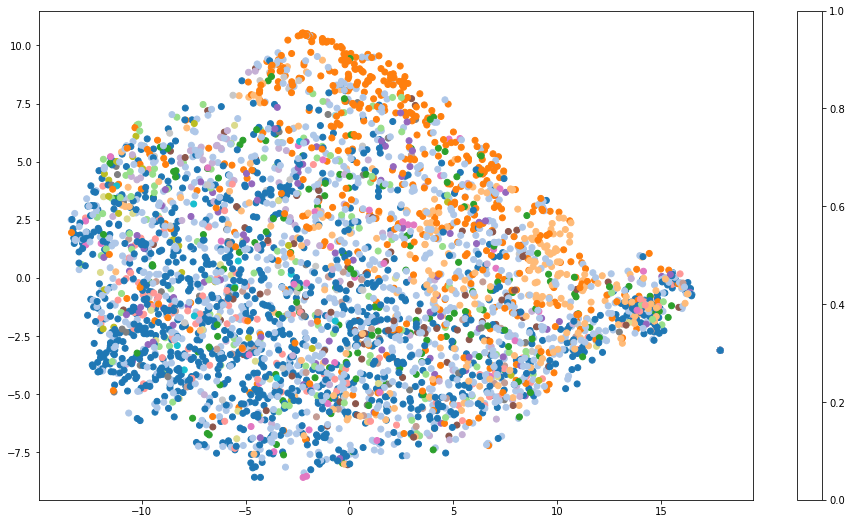

In [104]:
plt.figure(figsize=(16,9))
cmap = plt.cm.get_cmap("tab20", 18)

x = df_movie_embedding['x-tsne'].values
y = df_movie_embedding['y-tsne'].values
c = df_movie_embedding['Genres_label'].values


sc = plt.scatter(x, y, c=c, cmap=cmap)
plt.colorbar(ticks=['a','b'])
plt.clim(-0.5, 17.5)
plt.show()

In [90]:
df_Genres = pd.DataFrame(genre_list)
df_Genres

,0
0,Drama
1,Comedy
2,Action
3,Horror
4,Adventure
5,Crime
6,Documentary
7,Thriller
8,Animation
9,Children's
